In [3]:
# IMPORT NECESSARY LIBRARIES
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import scipy
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import joblib
import random
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# DATASET DOWNLOAD

def download_dataset(): 
    # Set the environment variable to point to the directory containing your .json file
    os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()  # Make sure kaggle.json is in the current directory
    
    # Use the kaggle API to download the dataset
    os.system('kaggle datasets download -d emmarex/plantdisease --unzip')

download_dataset():

print("Dataset downloaded and unzipped in ", os.getcwd())

Dataset downloaded and unzipped in  /Users/rhoust/Documents/School/CSOM/Fall 2024/Advanced_ML/Project/Code


In [24]:
# DATA PREPROCESSING

# Paths for input and output directories
input_dir = 'PlantVillage'
output_dir = 'PlantVillage_Preprocessed'
target_size = (128, 128)

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Get a count of all image files for the progress bar
image_files = []

for subdir, _, files in os.walk(input_dir):
    for file in files: 
        # Skip hidden files (e.g., .DS_Store on macOS)
        if file.startswith('.'):
            continue
        # Construct full file path for each image and add to image_files list
        full_path = os.path.join(subdir, file)
        image_files.append(full_path)

# Function to resize, normalize, and augment images with progress bar
def preprocess_images(input_dir, output_dir, target_size):
    for img_path in tqdm(image_files, desc="Processing Images"):
        image = cv2.imread(img_path)

        # BASIC ERROR CHECK: DO NOT PREPROCESS IMAGES THAT ARE MISSING / CORRUPT
        if image is not None:
            # Resize the image
            resized_image = cv2.resize(image, target_size)

            # Normalize the image to range [0, 1]
            normalized_image = resized_image / 255.0

            # Expand dimensions to match the input shape of ImageDataGenerator (batch size of 1)
            normalized_image = np.expand_dims(normalized_image, axis=0)

            # Apply augmentation
            i = 0
            for batch in datagen.flow(
                normalized_image, batch_size=1, save_to_dir=None,
                save_prefix='aug', save_format='jpg'
            ):
                # Save augmented image to the output directory
                relative_path = os.path.relpath(os.path.dirname(img_path), input_dir)
                save_dir = os.path.join(output_dir, relative_path)
                os.makedirs(save_dir, exist_ok=True)

                save_path = os.path.join(save_dir, f'aug_{i}_{os.path.basename(img_path)}')
                cv2.imwrite(save_path, (batch[0] * 255).astype(np.uint8))
                i += 1

                # Save only one augmented version per image to limit disk space usage
                if i >= 1:
                    break

# Run the preprocessing function
preprocess_images(input_dir, output_dir, target_size)

print("All images have been resized, normalized, augmented, and saved to ", os.getcwd())


Processing Images: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 41278/41278 [01:25<00:00, 481.63it/s]

All images have been resized, normalized, augmented, and saved to  /Users/rhoust/Documents/School/CSOM/Fall 2024/Advanced_ML/Project/Code


In [7]:
# TRAINING / TEST SPLIT 

# Define directories for the split
original_dir = "PlantVillage_Preprocessed"
base_dir = "PlantVillage_Split"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create target directories for train, val, and test splits 
for split_dir in tqdm([train_dir, val_dir, test_dir], desc="Creating Split Directories"):
    if not os.path.exists(split_dir): 
        os.makedirs(split_dir)

# Collect all image paths and corresponding labels 
image_paths = []
labels = []

for label in tqdm(os.listdir(original_dir), "Collecting Images"):
    label_dir = os.path.join(original_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir): 
            image_path = os.path.join(label_dir, image_file)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(label)

# Split data into training, validation, and test sets (e.g., 70% train, 15% val, 15% test)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, stratify=test_labels, random_state=42
)

# Helper function to copy files to their respective directories
def copy_files(image_paths, labels, split_dir):
    for image_path, label in tqdm(zip(image_paths, labels), desc="Copying Files"):
        label_dir = os.path.join(split_dir, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        shutil.copy(image_path, os.path.join(label_dir, os.path.basename(image_path)))

# Copy the files to their respective split directories
copy_files(train_paths, train_labels, train_dir)
copy_files(val_paths, val_labels, val_dir)
copy_files(test_paths, test_labels, test_dir)

print("Data split and copied successfully!")

Creating Split Directories: 100%|███████████████| 3/3 [00:00<00:00, 2356.79it/s]
Copying Files: 14446it [00:06, 2136.06it/s]
Copying Files: 3096it [00:01, 2563.29it/s]
Copying Files: 3096it [00:01, 2744.86it/s]

Data split and copied successfully!


In [10]:
# CNN ARCHITECTURE AND IMPLEMENTATION 

# Number of classes in dataset
num_classes = 15

# Initialize the CNN model 
CNN = models.Sequential()

# Create input layer that accepts dataset image size
CNN.add(layers.Input((128,128,3)))

# Convolutional Layer 1 (32 units, 3,3 kernel, relu activation), w MaxPooling technique
CNN.add(layers.Conv2D(32, (3,3), activation='relu'))
CNN.add(layers.MaxPooling2D((2,2)))

# Convolutional Layer 2, w MaxPooling
CNN.add(layers.Conv2D(64, (3,3), activation='relu'))
CNN.add(layers.MaxPooling2D((2,2)))
        
# Convolutional Layer 3, w MaxPooling
CNN.add(layers.Conv2D(128, (3,3), activation='relu'))
CNN.add(layers.MaxPooling2D((2,2)))

# Convolutional Layer 4, w MaxPooling
CNN.add(layers.Conv2D(256, (3,3), activation='relu'))
CNN.add(layers.MaxPooling2D((2,2)))

# Convolutional Layer 5, w MaxPooling     
CNN.add(layers.Conv2D(128, (3,3), activation='relu'))
CNN.add(layers.MaxPooling2D((2,2)))
        
# Flatten the layer 
CNN.add(layers.Flatten())

# Fully connected layer
CNN.add(layers.Dense(128, activation='relu'))

# Use dropout as a regularization technique (drops 35% of feature set)
CNN.add(layers.Dropout(0.35))

# Output layer (using softmax for multi-class classification)
CNN.add(layers.Dense(num_classes, activation='softmax'))

# Compile CNN using adam optimization and sparse categorical crossentropy 
CNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,055 (2.87 MB)

 Trainable params: 751,055 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# TRAIN MODEL 

training_path = 'PlantVillage_Split/train'
validation_path = 'PlantVillage_Split/val'


# Create training and validation generators 
train_dataset = tf.keras.utils.image_dataset_from_directory(
    training_path, 
    image_size=(128,128),
    batch_size=32
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    image_size=(128,128),
    batch_size=32
)

# Prepare computer resources efficiently - preload datasets while some are processing
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Create EarlyStopping object - stops training when loss value deteriorates on validation set
early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training CNN (25 epochs, use early stopper callback)
training = CNN.fit(
    train_dataset,
    epochs=25,
    validation_data = validation_dataset,
    callbacks=[early_stopper]
)

# Save trained model to cwd
joblib.dump(CNN, 'trained_CNN.pk1')

Found 14446 files belonging to 15 classes.
Found 3096 files belonging to 15 classes.
Epoch 1/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - accuracy: 0.2150 - loss: 3.2522 - val_accuracy: 0.4629 - val_loss: 1.6682
Epoch 2/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - accuracy: 0.5006 - loss: 1.5782 - val_accuracy: 0.6483 - val_loss: 1.0349
Epoch 3/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - accuracy: 0.6427 - loss: 1.0899 - val_accuracy: 0.7332 - val_loss: 0.8226
Epoch 4/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - accuracy: 0.7171 - loss: 0.8631 - val_accuracy: 0.7581 - val_loss: 0.7030
Epoch 5/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.7690 - loss: 0.7043 - val_accuracy: 0.8046 - val_loss: 0.6023
Epoch 6/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.7939 - loss: 0.6210 - val_accuracy: 0.8030 - val_loss: 0.5992
Epoch 7/25
452/452 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.8212 - loss: 0.5267 - val_accuracy: 0.8169 - val_loss: 0.587

['trained_CNN.pk1']

In [13]:
# EVALUATING MODEL ACCURACY ON TEST DATA

# Establish test file path and load in dumped CNN model 
test_path = 'PlantVillage_Split/test'
CNN = joblib.load('trained_CNN.pk1')

# Initialize keras dataset for test data
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path, 
    image_size=(128,128),
    batch_size=32,
    shuffle=True
)

# Evaluate
test_loss, test_accuracy = CNN.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Found 3096 files belonging to 15 classes.
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8334 - loss: 0.4920
Test Loss: 0.4845602214336395, Test Accuracy: 0.8346253037452698


--- Displaying some test images...


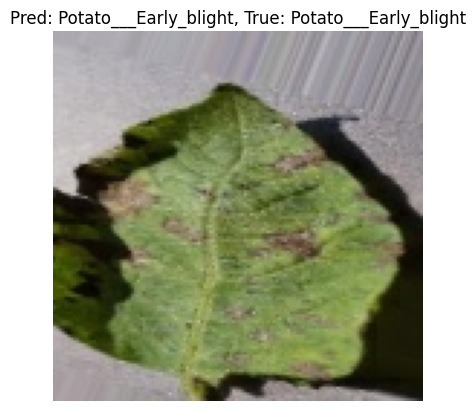

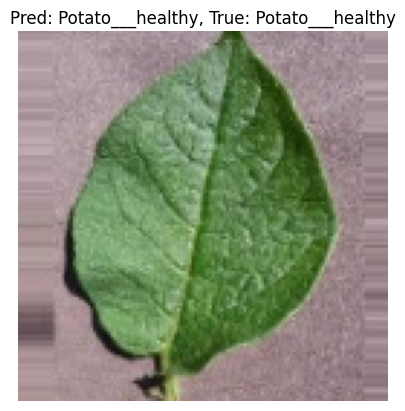

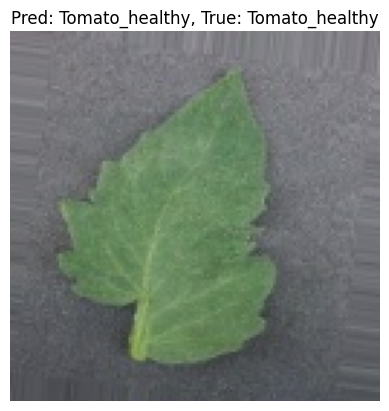

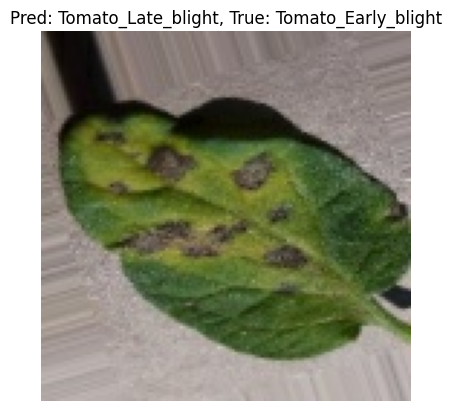

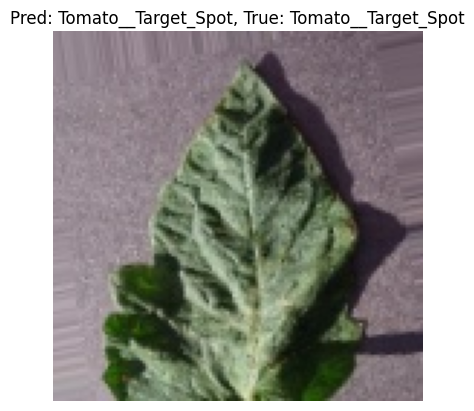

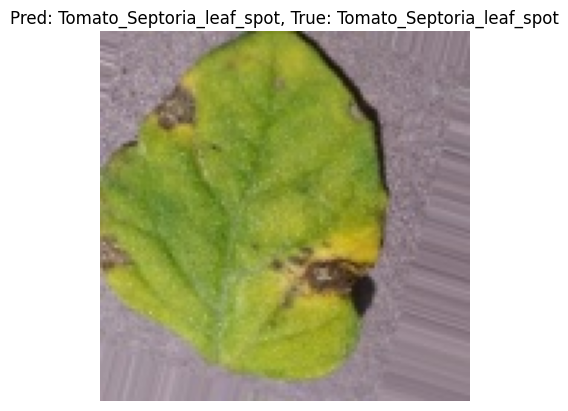

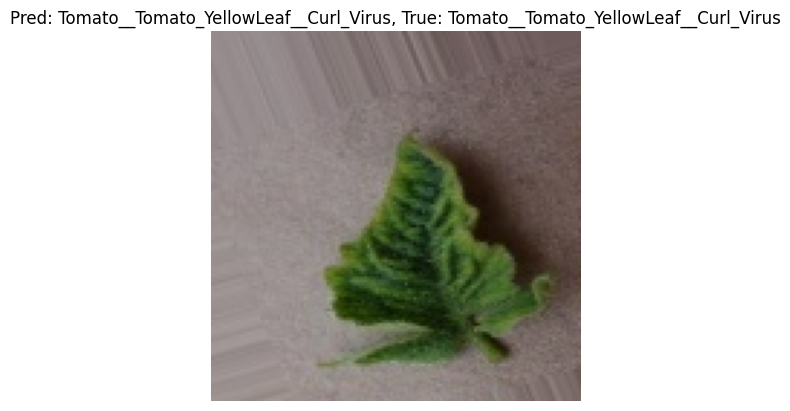

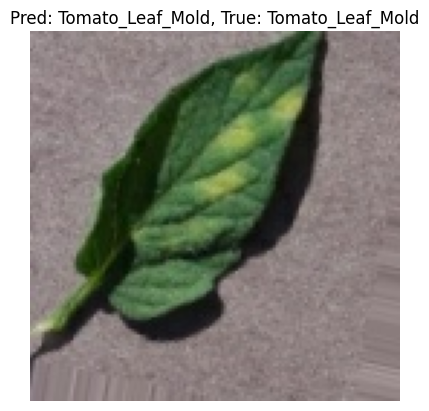

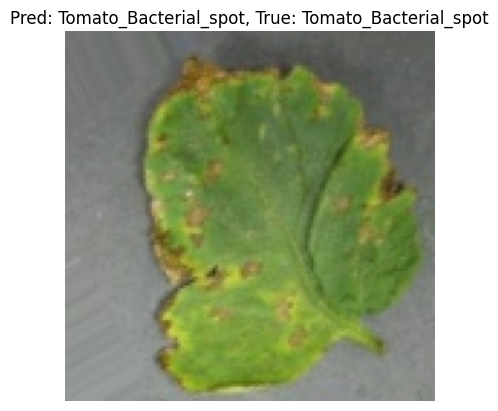

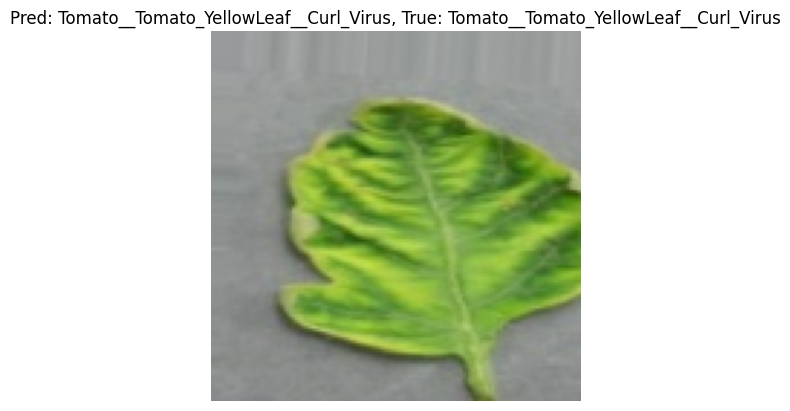

In [15]:
# DISPLAYING TEST IMAGES (RANDOM)

images = []
labels = []

# Take 10 shuffled batches from the test dataset and load them into lists
for image, label in test_dataset.take(10):
    images.append(image)
    labels.append(label)

print("--- Displaying some test images...")

# Pull out a random image from all 10 batches - show the prediction and actual values for the images
for i in range(10): 

    idx = random.randint(0,9)
    sub_idx = random.randint(0,31)

    # select test image
    test_img = images[idx][sub_idx]

    # get truth and prediction vals
    truth = labels[idx][sub_idx].numpy()
    prediction = np.argmax(CNN.predict(tf.expand_dims(test_img, axis=0), verbose=0))

    # Display
    plt.imshow(test_img.numpy().astype("uint8"))
    plt.axis('off')
    plt.title(f"Pred: {test_dataset.class_names[prediction]}, True: {test_dataset.class_names[truth]}")
    plt.show()